In [1]:
import torch
import triton
import triton.language as tl

/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [ ]:
class VALUES_INDICES:
    def __init__(self, values, indices):
        self.values = values
        self.indices = indices

@triton.jit
def _max_short(INPUT, VALUES, INDICES,
          stride0, stride1,
          M, N: tl.constexpr, 
          BLOCK_M: tl.constexpr, BLOCK_N: tl.constexpr):
    
    start_m = tl.program_id(0)
    input_offset = start_m * BLOCK_M * stride0
    input_ptrs = INPUT + input_offset +  tl.arange(0, BLOCK_M)[:, None] * stride0 + tl.arange(0, BLOCK_N)[None, :]
    mask_row = (start_m * BLOCK_M + tl.arange(0, BLOCK_M)[:, None]) < M
    mask_col = tl.arange(0, BLOCK_N) < N
    mask = mask_row & mask_col
    inp = tl.load(input_ptrs, mask=mask, other=float('-inf'))
    max_num, index = tl.max(inp, -1, return_indices=True)
    output_ptrs = VALUES + start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    tl.store(output_ptrs, max_num, mask=(start_m * BLOCK_M + tl.arange(0, BLOCK_M)) < M)
    indices_ptrs = INDICES + start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    tl.store(indices_ptrs, index, mask=(start_m * BLOCK_M + tl.arange(0, BLOCK_M)) < M)

@triton.jit
def _max_long(INPUT, VALUES, INDICES,
          stride0, stride1,
          M, N: tl.constexpr, 
          BLOCK_N: tl.constexpr):
    start_m = tl.program_id(0)
    base_ptrs = INPUT + start_m * stride0


    INPUT_ptrs = base_ptrs + tl.arange(0, BLOCK_N)
    mask = tl.arange(0, BLOCK_N) < N
    inp = tl.load(INPUT_ptrs, mask=mask)
    max_num, indices = tl.max(inp, 0, return_indices=True)  

    for start_n in range(BLOCK_N, N, BLOCK_N):
        INPUT_ptrs = base_ptrs + start_n  + tl.arange(0, BLOCK_N)
        mask = (start_n + tl.arange(0, BLOCK_N)) < N
        inp = tl.load(INPUT_ptrs, mask=mask)
        new_max_num, new_indices = tl.max(inp, 0, return_indices=True)  
        if new_max_num > max_num:
            max_num = new_max_num
            indices = start_n + new_indices

    tl.store(VALUES + start_m, max_num)
    tl.store(INDICES + start_m, indices)

def triton_max(tensor, axis=-1):
    # tensor = tensor.unsqueeze(-1)
    # if axis < 0:
    #     axis -= 1
    # tensor = tensor.transpose(axis, -1).squeeze(axis)
    tensor = torch.movedim(tensor, axis, -1)
    tensor_shape = tensor.shape
    tensor = tensor.reshape(-1, tensor_shape[-1])
    B,D = tensor.shape
    values = torch.empty(B, device=tensor.device, dtype=tensor.dtype)
    indices = torch.empty(B, device=tensor.device, dtype=torch.int64)
    if D <=256:
        tmp = triton.next_power_of_2(B)
        BLOCK_M= min(256, tmp)
        BLOCK_N=triton.next_power_of_2(D)
        grid = lambda meta: (triton.cdiv(B, meta['BLOCK_M']),)
        _max_short[grid](tensor, values, indices,
                tensor.stride(0),tensor.stride(1),
                    B,D,
                    BLOCK_M=BLOCK_M, BLOCK_N=BLOCK_N,
                    num_stages=4, num_warps=8
        )
    else:
        BLOCK_N = min(triton.next_power_of_2(D), 64*1024)
        _max_long[(B,)](tensor, values, indices, 
                tensor.stride(0),tensor.stride(1),
                    B,D,
                    BLOCK_N=BLOCK_N,
                    num_stages=4, num_warps=8
        )
    return VALUES_INDICES(values.reshape(*tensor_shape[:-1]),indices.reshape(*tensor_shape[:-1]))

In [14]:
x = torch.randn(64,64,64).cuda().to(torch.float16)
print(torch.allclose(triton_max(x, -1).values, x.max(-1).values))
print(torch.allclose(triton_max(x, -1).indices, x.max(-1).indices))
x = torch.randn(8,1, 64*1024).cuda().to(torch.float16)
print(torch.allclose(triton_max(x, -1).values, x.max(-1).values))
print(torch.allclose(triton_max(x, -1).indices, x.max(-1).indices))

True
True
True
True


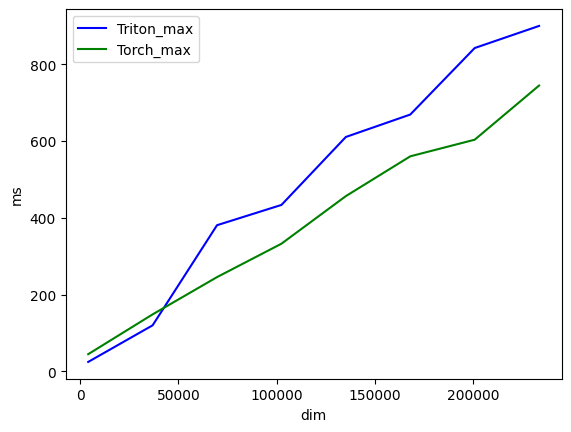

triton max:
        dim  Triton_max   Torch_max
0    4096.0   24.544731   44.702817
1   36864.0  119.910926  148.435920
2   69632.0  380.831987  245.589122
3  102400.0  433.687776  332.639873
4  135168.0  610.791147  456.679404
5  167936.0  669.254661  560.364842
6  200704.0  842.589378  603.660107
7  233472.0  900.199056  744.872153


In [21]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[4096 * i for i in range(1, 64+1, 8)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton_max",
            "Torch_max",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="triton max",  # name for the plot. Used also as a file name for saving the plot.
        args={'bs': 2046, 'axis': -1}
    ))
def benchmark(bs, dim, axis, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    tensor = torch.randn(bs, dim).to(device).to(dtype)

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_max(tensor, axis))

    if provider == 'torch':
        # ms = triton.testing.do_bench(lambda: torch.max(tensor, 2))
        ms = triton.testing.do_bench(lambda: torch.max(tensor, axis))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)


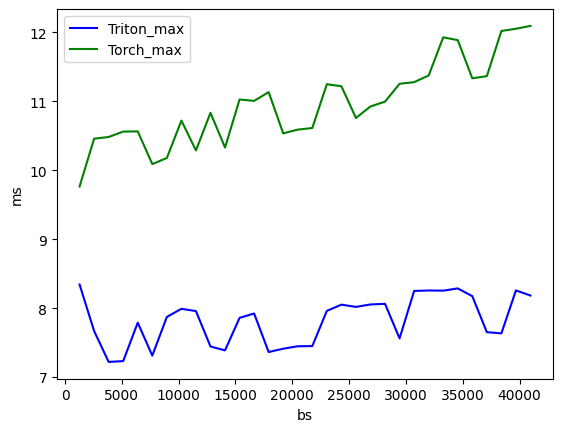

triton max:
         bs  Triton_max  Torch_max
0    1280.0    8.342327   9.763741
1    2560.0    7.667968  10.456789
2    3840.0    7.220017  10.481628
3    5120.0    7.232399  10.559773
4    6400.0    7.789487  10.562697
5    7680.0    7.310618  10.088711
6    8960.0    7.872044  10.176948
7   10240.0    7.990192  10.719137
8   11520.0    7.957065  10.287027
9   12800.0    7.443511  10.832317
10  14080.0    7.387453  10.328588
11  15360.0    7.858776  11.025427
12  16640.0    7.922016  11.005091
13  17920.0    7.363467  11.132495
14  19200.0    7.411625  10.533811
15  20480.0    7.447091  10.588511
16  21760.0    7.449510  10.611612
17  23040.0    7.960197  11.246789
18  24320.0    8.050247  11.217527
19  25600.0    8.017967  10.757823
20  26880.0    8.053318  10.924291
21  28160.0    8.062413  10.994112
22  29440.0    7.560875  11.253273
23  30720.0    8.249084  11.276530
24  32000.0    8.255955  11.373325
25  33280.0    8.253472  11.926454
26  34560.0    8.285843  11.885997
27  3584

In [17]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['bs'],  # argument names to use as an x-axis for the plot
        x_vals=[1280 * i for i in range(1, 32+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton_max",
            "Torch_max",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="triton max",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 4, 'axis': -1}
    ))
def benchmark(bs, dim, axis, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    tensor = torch.randn(bs, dim).to(device).to(dtype)

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_max(tensor, axis))

    if provider == 'torch':
        # ms = triton.testing.do_bench(lambda: torch.max(tensor, 2))
        ms = triton.testing.do_bench(lambda: torch.max(tensor, axis))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)


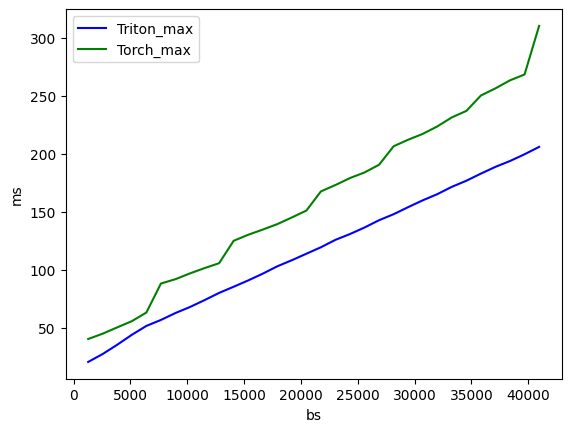

triton max:
         bs  Triton_max   Torch_max
0    1280.0   20.845547   40.591251
1    2560.0   27.688870   45.187268
2    3840.0   35.681445   50.614502
3    5120.0   44.204023   55.940293
4    6400.0   51.851526   63.382603
5    7680.0   56.993391   88.350363
6    8960.0   62.958635   92.102945
7   10240.0   68.147406   97.081840
8   11520.0   74.067287  101.627305
9   12800.0   80.275707  105.835289
10  14080.0   85.581310  125.147700
11  15360.0   91.016106  130.329862
12  16640.0   96.836433  134.794891
13  17920.0  103.163615  139.494479
14  19200.0  108.419165  145.236656
15  20480.0  113.996804  151.174426
16  21760.0  119.585529  167.685404
17  23040.0  125.982076  173.184291
18  24320.0  130.977944  179.179654
19  25600.0  136.600211  184.000596
20  26880.0  142.892405  190.659150
21  28160.0  148.051605  206.554666
22  29440.0  154.137790  212.196320
23  30720.0  159.996226  217.201576
24  32000.0  165.300876  223.619476
25  33280.0  171.602339  231.408685
26  34560.0  176

In [19]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['bs'],  # argument names to use as an x-axis for the plot
        x_vals=[1280 * i for i in range(1, 32+1, 4)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton_max",
            "Torch_max",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="triton max",  # name for the plot. Used also as a file name for saving the plot.
        args={'dim': 4096, 'axis': -1}
    ))
def benchmark(bs, dim, axis, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    tensor = torch.randn(bs, dim).to(device).to(dtype)

    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_max(tensor, axis))

    if provider == 'torch':
        # ms = triton.testing.do_bench(lambda: torch.max(tensor, 2))
        ms = triton.testing.do_bench(lambda: torch.max(tensor, axis))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)
